
# Overview

By the end of this notebook, you will understand how to-

* Work with the audio data
* Represent an audio data - Time Domain and Spectrogram
* Build a deep learning model while working with audio data

<br>

# Understanding the Problem Statement

According to the National Crime Records Bureau, nearly 24,012 people die each day due to a delay in getting medical assistance. Many accident victims wait for help at the site, and a delay costs them their lives. The reasons could range from ambulances stuck in traffic to the fire brigade not being able to reach the site on time due to traffic jams. 

The solution to the above problem is to create a system that automatically detects the emergency vehicle prior to reaching the traffic signals and change the traffic signals accordingly.

<br>

# Dataset

Download the dataset from [here](https://drive.google.com/file/d/1VBI_X6GyYvf8j3T70-_hVDyhR_sUzeCr/view?usp=sharing)

<br>

## Import Libraries

Let us first import the libraries into our environment

* **Librosa** is an open source library in Python that is used for audio and music analyis

* **Scipy** is a python library for scientific & technical computing. It contains modules for signal processing, image processing, and linear algebera

In [1]:
# For audio processing
import librosa
import scipy

In [2]:
librosa.__version__

'0.10.1'

In [3]:
scipy.__version__  

'1.11.3'

In [4]:
# For playing audio
import IPython.display as ipd

# For array processing
import numpy as np

# For visualization 
import matplotlib.pyplot as plt

# Load Audio Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# extract data
!unzip '/content/drive/My Drive/Course_Notes/Applied DL - Sequence Models/Project 3: Audio Classification/audio.zip'

Archive:  /content/drive/My Drive/Course_Notes/Applied DL - Sequence Models/Project 3: Audio Classification/audio.zip
   creating: audio/
  inflating: audio/emergency.wav     
  inflating: audio/non emergency.wav  


In [5]:
# import emergency vehicle data
path='audio/emergency.wav'
emergency,sample_rate = librosa.load(path, sr = 16000)

# import non-emergency vehicle data
path='audio/non emergency.wav'
non_emergency,sample_rate = librosa.load(path, sr =16000)

We have used the sampling rate (sr) of 16000 to read the above audio data. An audio wave of 2 seconds with a sampling rate of 16,000 will have 32,000 samples.

__Find the duration of the audio clips__

In [7]:
duration1 = librosa.get_duration(y=emergency,sr=16000)
duration2 = librosa.get_duration(y=non_emergency,sr=16000)

print("Duration of an emergency and Non Emergency (in min):",duration1/60,duration2/60)

Duration of an emergency and Non Emergency (in min): 22.920290625 27.160834375


## Preparing Data

Let us break the audio into chunks of 2 seconds. So, let us define the function for the same task

In [8]:
def prepare_data(audio_data, num_of_samples=32000, sr=16000):
  
  data=[]
  for offset in range(0, len(audio_data), sr):
    start = offset
    end   = offset + num_of_samples
    chunk = audio_data[start:end]
    
    if(len(chunk)==32000):
      data.append(chunk)
    
  return data

Call the above function

In [9]:
# prepare audio chunks
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [10]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


Lets listen to some of the clips

In [11]:
ipd.Audio(emergency[136],rate=16000)

In [12]:
ipd.Audio(non_emergency[10],rate=16000)

## Visualization of Audio Data

Let's visualize the audio wave in time domain

Text(0, 0.5, 'Amplitude')

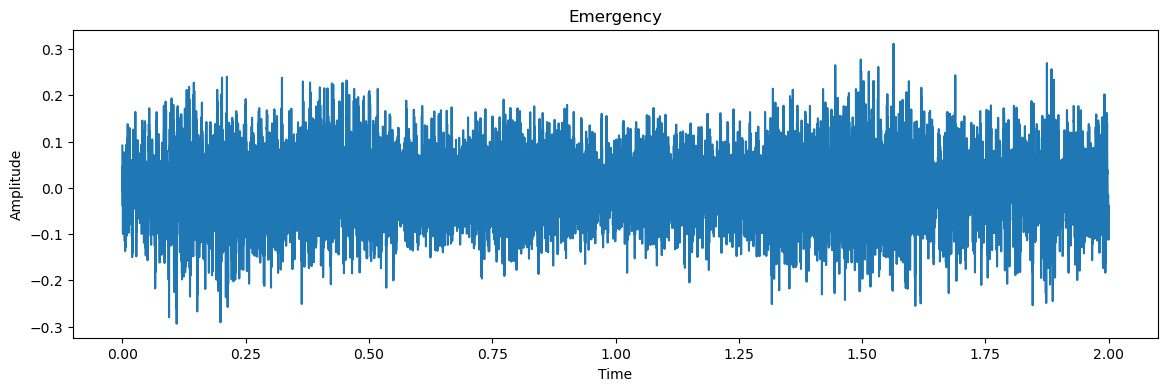

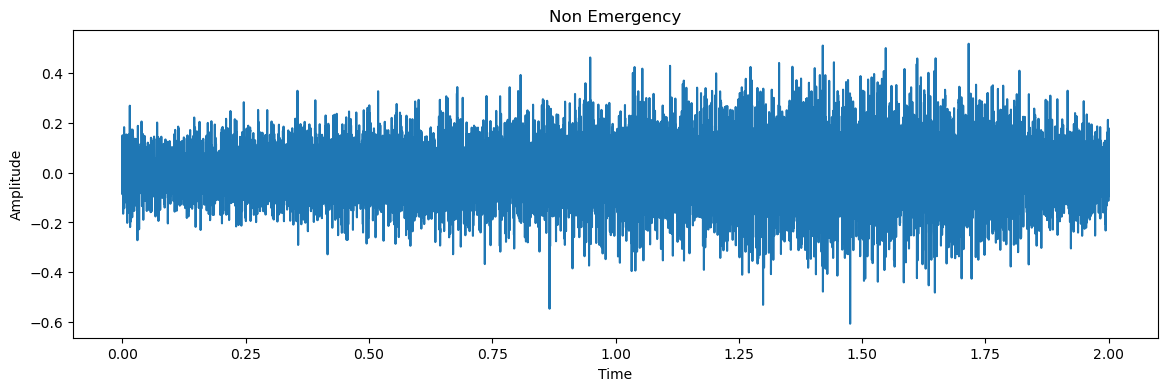

In [13]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

__Combine Emergecy and Non Emergency chunks__

In [14]:
audio = np.concatenate([emergency,non_emergency])

In [15]:
# assign labels 
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

# concatenate labels
labels = np.concatenate([labels1,labels2])

Take a glance at the shape of the combined data.

In [16]:
print(audio.shape)

(3002, 32000)


**Split into train and validation set**

Next, we will train the model on 90% of the data and validate on the remaining 10%:

In [17]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),
                                            stratify=labels,test_size = 0.1,
                                            random_state=777,shuffle=True)

In [18]:
x_tr.shape, x_val.shape

((2701, 32000), (301, 32000))

The input must be 3 dimensional array - (no. of examples, timesteps, features)

So, lets reshape our input array according to the required shape

In [19]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 32000, 1)


## Model Architecture

Let's define the model architecture using conv1D layers  and the time domain features.

In [20]:
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D, GlobalMaxPool1D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

# CNN based deep learning model architecture
def conv_model(x_tr):
  
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  # Global MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)

  #Dense Layer 
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)

  model = Model(inputs, outputs)
  
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  
  return model, model_checkpoint

2023-11-06 16:48:24.348637: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 16:48:24.400277: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 16:48:24.400358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 16:48:24.400436: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 16:48:24.412433: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 16:48:24.413296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

__Call the model__

In [21]:
model, model_checkpoint = conv_model(x_tr_features)

Understand the shape and parameters at each layer

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 32000, 8)          112       
                                                                 
 dropout (Dropout)           (None, 32000, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 16000, 8)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16000, 16)         1424      
                                                                 
 dropout_1 (Dropout)         (None, 16000, 16)         0         
                                                             

Lets train the model for 10 epochs:

In [24]:
# model training
history = model.fit(x_tr_features, y_tr ,epochs=2, 
                    callbacks=[model_checkpoint], batch_size=32, 
                    validation_data=(x_val_features,y_val))

Epoch 1/2
85/85 [==============================] - ETA: 0s - loss: 0.3379 - acc: 0.8619
Epoch 1: val_loss improved from 0.39978 to 0.37977, saving model to best_model.hdf5
85/85 [==============================] - 23s 273ms/step - loss: 0.3379 - acc: 0.8619 - val_loss: 0.3798 - val_acc: 0.8605
Epoch 2/2
85/85 [==============================] - ETA: 0s - loss: 0.3270 - acc: 0.8700
Epoch 2: val_loss improved from 0.37977 to 0.37137, saving model to best_model.hdf5
85/85 [==============================] - 24s 283ms/step - loss: 0.3270 - acc: 0.8700 - val_loss: 0.3714 - val_acc: 0.8472


In [25]:
# load the best model weights
model.load_weights('best_model.hdf5')

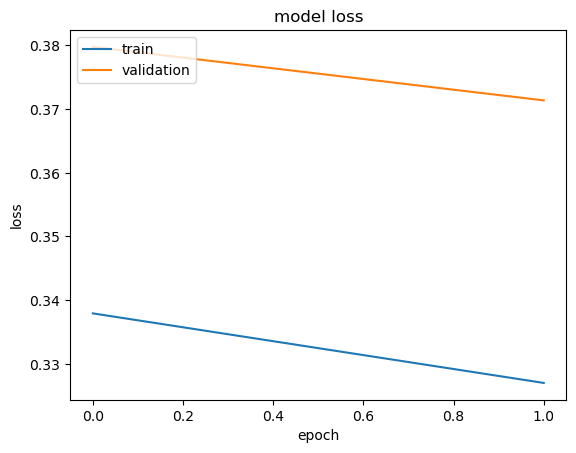

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluate the model on hold out set

In [27]:
# check model's performance on the validation set
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)

10/10 [==============================] - 0s 44ms/step - loss: 0.3714 - acc: 0.8472
Validation Accuracy: 0.8471760749816895


**Inference**

Let us make predictions on the hold out set

In [28]:
# input audio

ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [29]:
# classification
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5):
  pred='emergency'
else:
  pred='non emergency' 

print("Prediction:",pred)

1/1 [==============================] - 0s 126ms/step
Prediction: emergency


<br>

Let's define the model architecture using LSTM layers and the time domain features.

In [30]:
# reshape chunks
x_tr_features  = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [31]:
from keras.layers import LSTM

# LSTM based deep learning model architecture
def lstm_model(x_tr):
  
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)
  
  #dense
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)
  
  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  
  return model

In [32]:
model = lstm_model(x_tr_features)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 160)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               147968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 156289 (610.50 KB)
Trainable params: 156289 (610.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [34]:
history=model.fit(x_tr_features, y_tr, epochs=2, 
                  callbacks=[mc], batch_size=32, 
                  validation_data=(x_val_features,y_val))

Epoch 1/2
85/85 [==============================] - ETA: 0s - loss: 0.6454 - acc: 0.6142
Epoch 1: val_loss improved from inf to 0.58706, saving model to best_model.hdf5
85/85 [==============================] - 13s 130ms/step - loss: 0.6454 - acc: 0.6142 - val_loss: 0.5871 - val_acc: 0.6877
Epoch 2/2
85/85 [==============================] - ETA: 0s - loss: 0.5838 - acc: 0.7031
Epoch 2: val_loss improved from 0.58706 to 0.51546, saving model to best_model.hdf5
85/85 [==============================] - 9s 109ms/step - loss: 0.5838 - acc: 0.7031 - val_loss: 0.5155 - val_acc: 0.7674


In [35]:
# load best model weights
model.load_weights('best_model.hdf5')

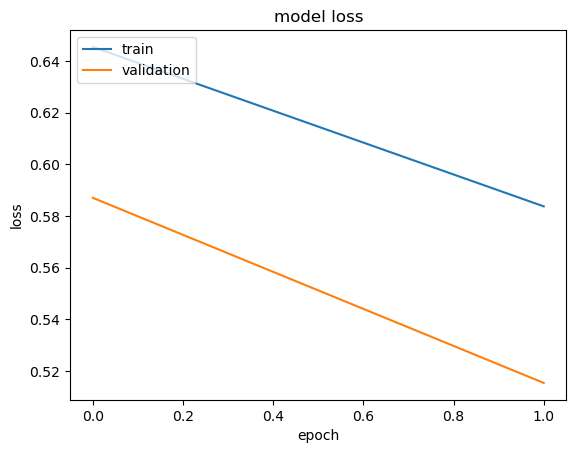

In [36]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 1s 66ms/step - loss: 0.5155 - acc: 0.7674
Accuracy: 0.7674418687820435


## Spectrogram Features

Let us define a function that computes the spectrogram. Before that, we need to understand how the spectrogram is computed.

Spectrogram accepts the raw audio wave and then breaks it into chunks or windows and then applies FFT on each window to compute the frequencies.

Coming to the parameters for computing spectrogram: 

* nperseg = Size of the window i.e. number of samples in each chunk
* noverlap= Number of overlapping samples between each window

In [38]:
def log_specgram(audio, sample_rate, eps=1e-10):
    nperseg  = 320
    noverlap = 160

    freqs, times, spec = scipy.signal.spectrogram(audio,fs=sample_rate, nperseg=nperseg,noverlap=noverlap)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Define a function for representing spectrogram:

In [39]:
def plot(spectrogram,label):
  fig = plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(211)
  ax.imshow(spectrogram.T, aspect='auto', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax.set_title('Spectrogram of '+label)
  ax.set_ylabel('Freqs in Hz')
  ax.set_xlabel('Seconds')

Compute the spectrogram:

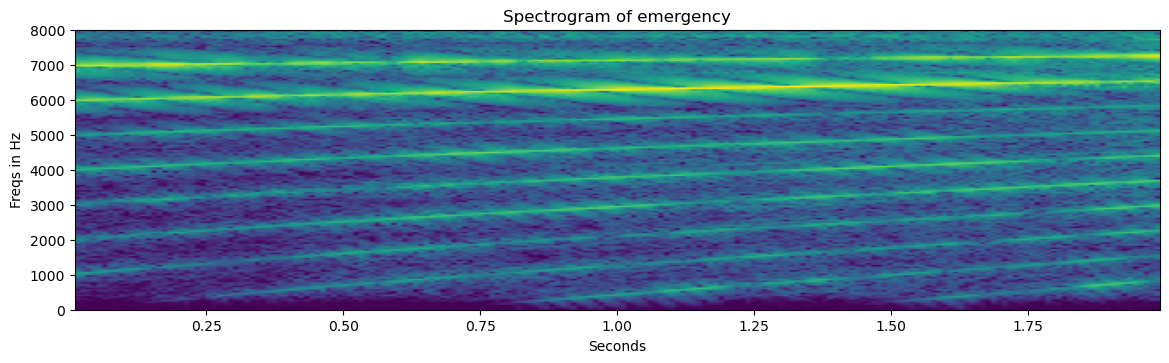

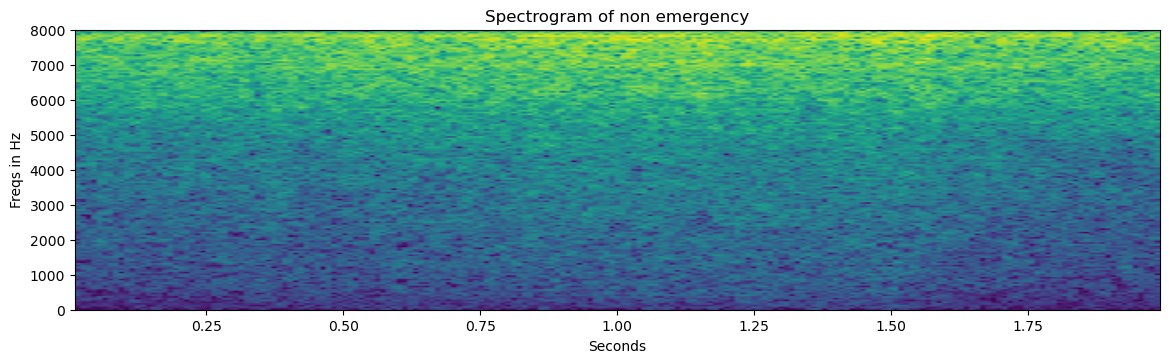

In [40]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")

freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

In [41]:
spectrogram.shape

(199, 161)

__Extract the spectrogram features__

In [42]:
def extract_spectrogram_features(x_tr):
  features=[]
  for i in x_tr:
    _, _, spectrogram = log_specgram(i, sample_rate)
    
    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std
    
    features.append(spectrogram)

  return np.array(features)

In [43]:
x_tr_features  = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

__Call the LSTM Model__

In [44]:
model_2 = lstm_model(x_tr_features)

In [45]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Understand the no. of parameters and shape of each layer:

In [46]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 199, 161)]        0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               148480    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 156801 (612.50 KB)
Trainable params: 156801 (612.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the model

In [47]:
history=model_2.fit(x_tr_features, y_tr, 
                    epochs=2, callbacks=[mc], batch_size=32, 
                    validation_data=(x_val_features,y_val))

Epoch 1/2
85/85 [==============================] - ETA: 0s - loss: 0.6596 - acc: 0.6146
Epoch 1: val_loss improved from inf to 0.60543, saving model to best_model.hdf5
85/85 [==============================] - 13s 125ms/step - loss: 0.6596 - acc: 0.6146 - val_loss: 0.6054 - val_acc: 0.6711
Epoch 2/2
85/85 [==============================] - ETA: 0s - loss: 0.4419 - acc: 0.8260
Epoch 2: val_loss improved from 0.60543 to 0.44261, saving model to best_model.hdf5
85/85 [==============================] - 9s 106ms/step - loss: 0.4419 - acc: 0.8260 - val_loss: 0.4426 - val_acc: 0.8571


Load the weights of the best model:

In [48]:
model_2.load_weights('best_model.hdf5')

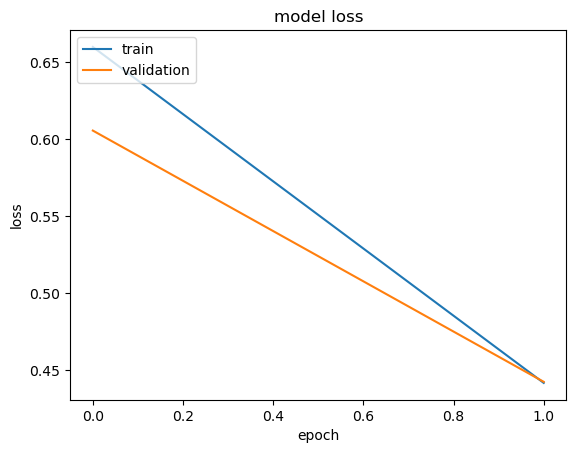

In [49]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluating the performance of the model on validation set:

In [50]:
_,acc = model_2.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 1s 64ms/step - loss: 0.4426 - acc: 0.8571
Accuracy: 0.8571428656578064


<br>

Lets train the CNN based model on the same spectrogram features.


In [51]:
model_3, mc = conv_model(x_tr_features)

Understand the input and output shape of each layer:

In [52]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 199, 161)]        0         
                                                                 
 conv1d_2 (Conv1D)           (None, 199, 8)            16752     
                                                                 
 dropout_4 (Dropout)         (None, 199, 8)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 99, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 99, 16)            1424      
                                                                 
 dropout_5 (Dropout)         (None, 99, 16)            0         
                                                           

Training the model:

In [53]:
history=model_3.fit(x_tr_features, y_tr, 
                    epochs=2, callbacks=[mc], batch_size=32, 
                    validation_data=(x_val_features,y_val))

Epoch 1/2
82/85 [===========================>..] - ETA: 0s - loss: 0.6553 - acc: 0.6562
Epoch 1: val_loss improved from inf to 0.50674, saving model to best_model.hdf5
85/85 [==============================] - 3s 25ms/step - loss: 0.6484 - acc: 0.6627 - val_loss: 0.5067 - val_acc: 0.8439
Epoch 2/2
82/85 [===========================>..] - ETA: 0s - loss: 0.3204 - acc: 0.8815
Epoch 2: val_loss improved from 0.50674 to 0.30206, saving model to best_model.hdf5
85/85 [==============================] - 2s 23ms/step - loss: 0.3188 - acc: 0.8819 - val_loss: 0.3021 - val_acc: 0.9136


Load the best saved model

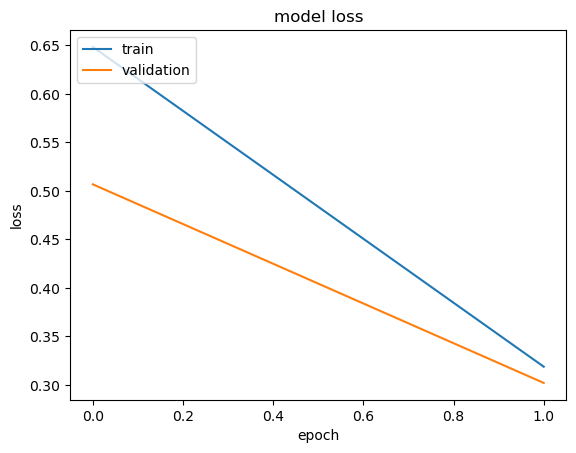

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluating the performance of the model:

In [55]:
model_3.load_weights('best_model.hdf5')

In [56]:
# model's performance on the validation set
_,acc = model_3.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 0s 6ms/step - loss: 0.3021 - acc: 0.9136
Accuracy: 0.9136212468147278


### What else to try?

* Different model architectures
* Use Frequency domain features
* Change input sequence length
* more...